In [1]:
import warnings
warnings.filterwarnings("ignore",)

In [2]:
# !pip install pmdarima

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sn 
from scipy import stats
import plotly.express as px
import statsmodels.api as sm
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import statsmodels.formula.api as smf 
from pmdarima.arima import auto_arima
from playsound import playsound as play
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing


In [4]:
df=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [5]:
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [6]:
# Checking duplicate values
df[df.duplicated()]

,Quarter,Sales


In [7]:
# Converting Quarter column to date time format
df['Date']=pd.to_datetime(df['Quarter'].apply(lambda x: '19'+''.join(x.split('_')[::-1])))

In [8]:
# Checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Quarter  42 non-null     object        
 1   Sales    42 non-null     float64       
 2   Date     42 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ KB


No null values present 

In [9]:
# Checking Statistical description
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [10]:
# Sales through out the year
fig=go.Figure(go.Scatter(x=df['Date'], 
                         y=df['Sales'],
                         mode='markers + lines',))

fig.update_layout(title='Coca Cola Sales ',
                  xaxis_title='Year',
                  yaxis_title='Count')
fig.show()

Sales are increasing every Year.<br>
Seems like in every year from 'April' to 'July' month sales are high compared to other month.<br>
People love to drink Coca Cola products on summer !

In [11]:
# Lets see which year they made heighest sale

df['Year']=df['Date'].dt.year  # making a column to store the year
temp_df= pd.DataFrame()
temp_df['Sum'] = df[['Sales','Year']].groupby('Year').sum().astype('int')

temp_df['average']=df[['Sales','Year']].groupby('Year').mean().astype('int')


In [12]:
temp_df.head()

,Sum,average
Year,,
1986,8668,2167
1987,7658,1914
1988,8337,2084
1989,8622,2155
1990,10236,2559


In [13]:
# Visuallizing it
fig= go.Figure()
fig.add_trace(go.Bar(x=temp_df.index, 
                     y=temp_df['Sum'],
                     text=temp_df['Sum'],
                     marker=dict(color=temp_df['Sum'],
                                 colorscale='rdylgn'),
                     hovertemplate='%{y}'))

fig.add_trace(go.Scatter(x=temp_df.index, 
                     y=temp_df['average'],
                     name='Average',
                     hovertemplate='%{y}',
                     marker=dict(color='#03fffb'),
                     ))

fig.update_layout(title='Sales in each year',
                  xaxis_title='Sales Count',
                  yaxis_title='Years',
                  autosize=False)

fig.show()

On the year 1987 sales decreases, then it gradually increases<br>
On the year 1996, again the sales decreases<br>
But average value of sales in each quarter is increased than previous year 

In [14]:
# Lets find how the average values is increased while the sales are down

df['Quarters']=df['Date'].dt.quarter

In [15]:
df.head()

,Quarter,Sales,Date,Year,Quarters
0,Q1_86,1734.827000,1986-01-01,1986,1
1,Q2_86,2244.960999,1986-04-01,1986,2
2,Q3_86,2533.804993,1986-07-01,1986,3
3,Q4_86,2154.962997,1986-10-01,1986,4
4,Q1_87,1547.818996,1987-01-01,1987,1


In [16]:
# line chart
fig=go.Figure()
for i in range(1,5):
    fig.add_scatter(x=df[df['Quarters']==i]['Year'],
                    y=df[df['Quarters']==i]['Sales'].astype('int'),
                    name=f'Q{i}')
fig.update_layout(title='Sales with Quarter',
                 xaxis_title='Year',
                 yaxis_title='Count',
                 autosize=False,
                 hovermode='x unified')
fig.show()

In [17]:
# Bar chart
fig=go.Figure()
for i in range(1,5):
    fig.add_bar(y=df[df['Quarters']==i]['Year'],
                x=df[df['Quarters']==i]['Sales'].astype('int'),
                text=df[df['Quarters']==i]['Sales'].astype('int'),
                orientation='h',
                name=f'Q{i}')
fig.update_layout(title='Sales with Quarter',
                 yaxis_title='Year',
                 xaxis_title='Count',
                 barmode='stack',
                 autosize=False,)
fig.show()

So we got our ans <br>
Because for year 1996 we have no information about Q3 and Q4 sales

In [18]:
# Box plot for each year
fig=go.Figure()
fig.add_box(x=df.Year, 
            y=df['Sales'],
            boxpoints='all',
            jitter=0.1,
            marker_size=2.5)
fig.update_layout(title='Sales in each year',
                  xaxis_title='Sales Count',
                  yaxis_title='Years',)
fig.show()

<AxesSubplot: xlabel='Sales', ylabel='Count'>

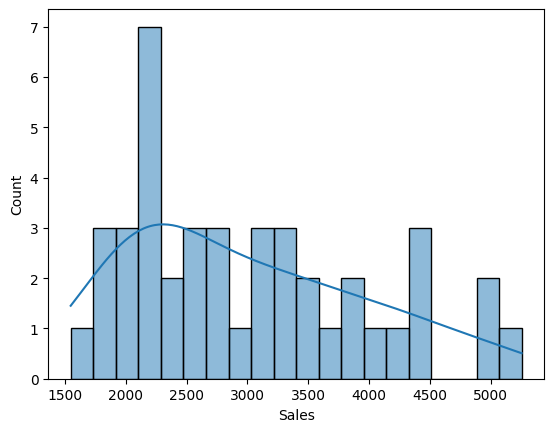

In [19]:
# Histogram of 'Salesr' column
sn.histplot(x=df['Sales'],bins=20,kde=True)

Slightly seems to be right skewed

In [20]:
df.head()

,Quarter,Sales,Date,Year,Quarters
0,Q1_86,1734.827000,1986-01-01,1986,1
1,Q2_86,2244.960999,1986-04-01,1986,2
2,Q3_86,2533.804993,1986-07-01,1986,3
3,Q4_86,2154.962997,1986-10-01,1986,4
4,Q1_87,1547.818996,1987-01-01,1987,1


### Finding Moving Average

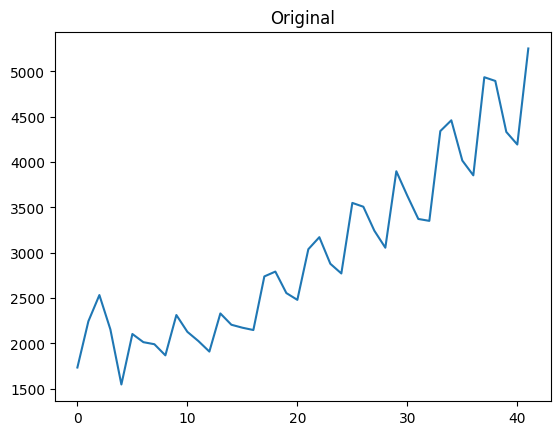

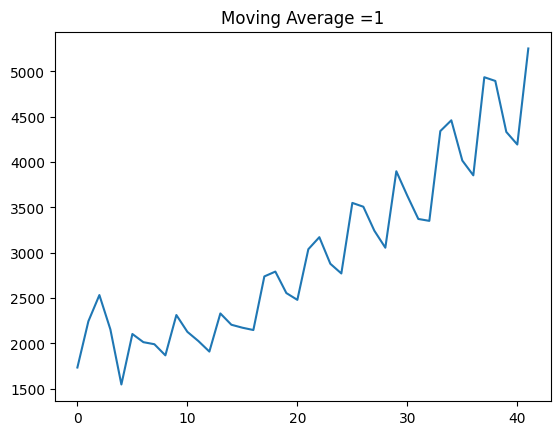

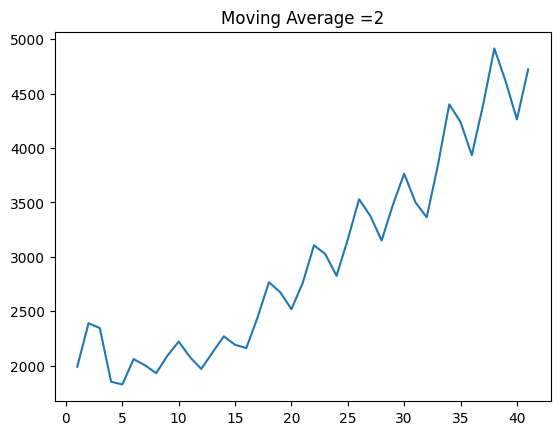

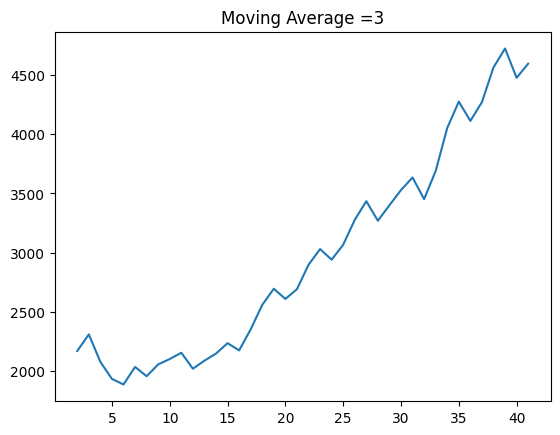

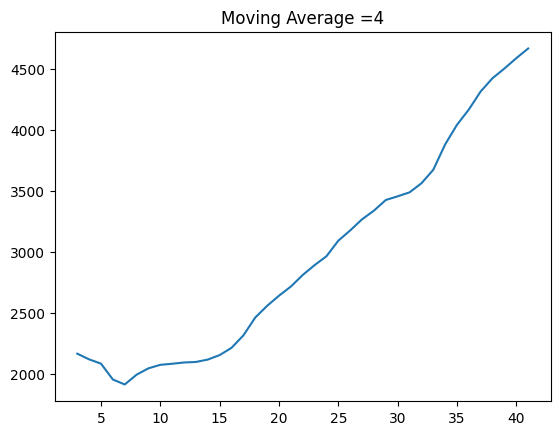

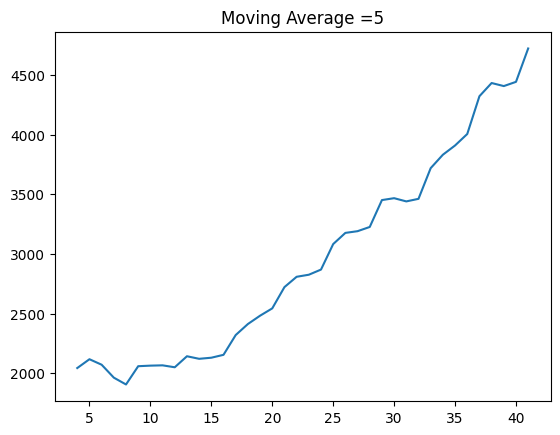

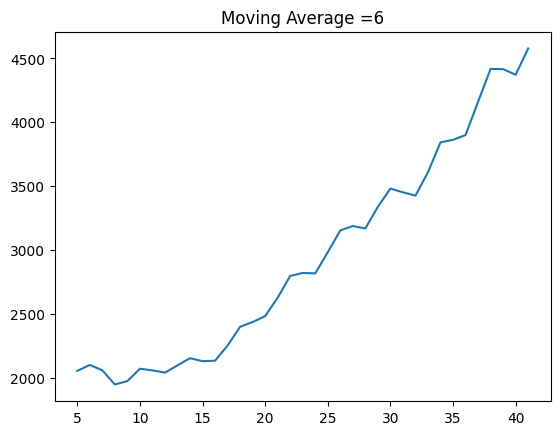

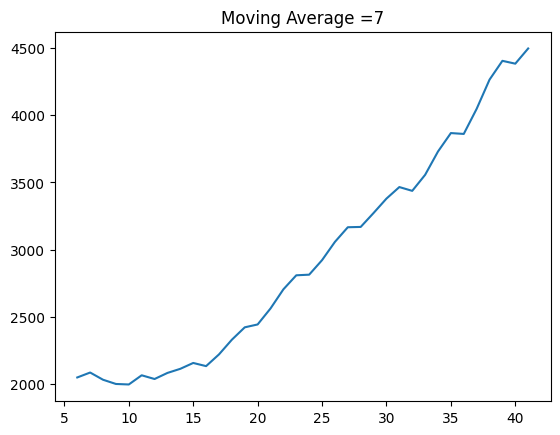

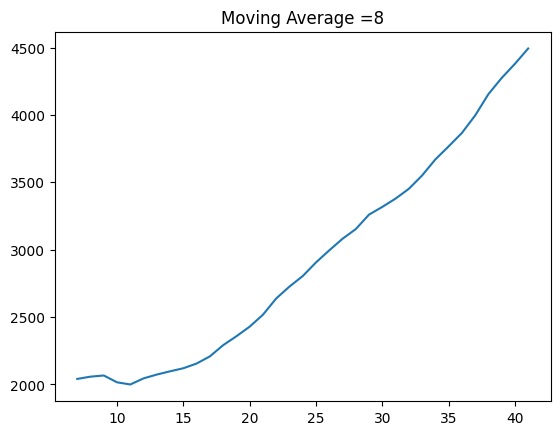

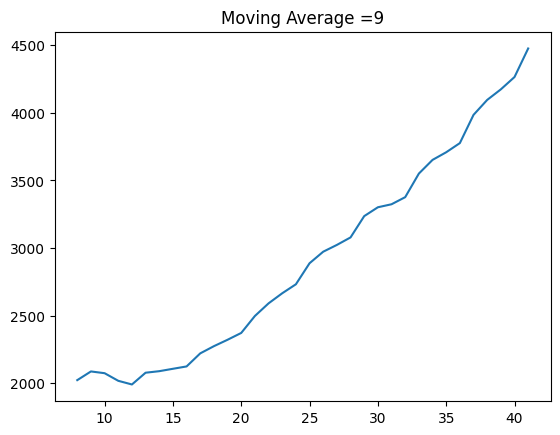

In [21]:
# Choosing moving average

plt.plot(df.Sales)
plt.title("Original")
plt.show()
for i in range(1,10):
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average ="+str(i))
    plt.show()

Choosing moving average = 4<br>
So our period is 4

In [22]:
# Checking hows it compare to original series
fig=go.Figure()
fig.add_scatter(y=df.Sales,name='Original')
fig.add_scatter(y=df["Sales"].rolling(4).mean(),name='With MA 4',line=dict(dash='dashdot'))
fig.show()



### Time Series Decomposition

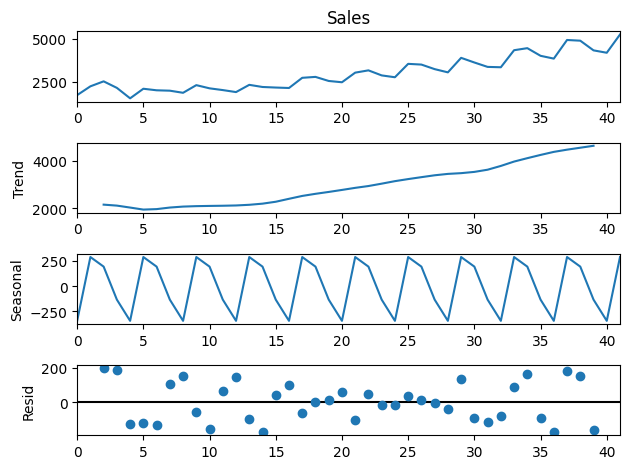

In [23]:
# Time series Additive decomposition plot

decompose_ts_add=seasonal_decompose(df.Sales,period=4)
decompose_ts_add.plot()
plt.show()

Trend varies between 2000 to 4000<br>
Seasonality varies between -250 to 250<br>
Resid/Noise vary between -200 to 200

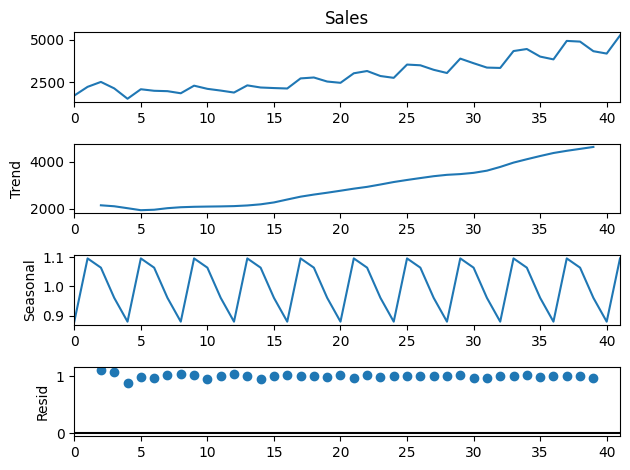

In [24]:
# Time series Multiplicative decomposition plot

decompose_ts_add=seasonal_decompose(df.Sales,period=4,model='multiplicative')
decompose_ts_add.plot()
plt.show()

In [25]:
# Splitting our data for validation purposes
df.shape

(42, 5)

In [26]:
df.head()

,Quarter,Sales,Date,Year,Quarters
0,Q1_86,1734.827000,1986-01-01,1986,1
1,Q2_86,2244.960999,1986-04-01,1986,2
2,Q3_86,2533.804993,1986-07-01,1986,3
3,Q4_86,2154.962997,1986-10-01,1986,4
4,Q1_87,1547.818996,1987-01-01,1987,1


In [27]:
train_data,test_data=df.iloc[:math.ceil(len(df)*0.8),[2,1]],df.iloc[math.ceil(len(df)*0.8):,[2,1]]

In [28]:
# Checking shapes
train_data.shape, test_data.shape

((34, 2), (8, 2))

In [29]:
# Visualizing with graphs
fig=go.Figure()
fig.add_scatter(x=train_data['Date'],y=train_data['Sales'],name='Train Data')
fig.add_scatter(x=test_data['Date'],y=test_data['Sales'],name='Test Data')
# fig.update_traces(mode='lines+markers',)
fig.update_layout(title='Train and Test set')
fig.show()

In [30]:
# A function to compare all scores
def plot_me(new_traces=[]):
    traces=[]
    traces.append(go.Scatter(x=train_data['Date'],y=train_data['Sales'],name='Train Data'))
    traces.append(go.Scatter(x=test_data['Date'],y=test_data['Sales'],name='Test Data'))
    traces.extend(new_traces)
    fig=go.Figure(traces)
    fig.update_layout(title="<b>Comparing different model with original data</b>",
                      xaxis_title="Date",
                      yaxis_title="total Sales",
                      hovermode="x unified")
    fig.update_traces(mode='lines')
    fig.show()

### Simple Exponential Method

In [31]:
# first we need to find the suitable smoothing_level which is a hyperparameter

temp_storage=[]
temp_range=np.linspace(0.1,1,20)
for i in temp_range:
    test_model= SimpleExpSmoothing(train_data['Sales']).fit(smoothing_level=i)
    temp_storage.append(MAPE(test_data['Sales'],test_model.predict(start=test_data.index[0],end=test_data.index[-1])))
    
fig=go.Figure()
fig.add_bar(x=temp_range,y=temp_storage,text=temp_storage,marker=dict(color=temp_storage,
                                                    colorscale='greens',))
fig.update_layout(title='Choosing hyperparameter',
                  xaxis_title='Smoothing level',
                  yaxis_title='MAPE',)
fig.show()

Choosing smoothing_level to 1 as it has the lowest MAPE

In [32]:
sem_model = SimpleExpSmoothing(train_data['Sales']).fit(smoothing_level=1)
sem_predicted=sem_model.predict(start=test_data.index[0],end=test_data.index[-1])

In [33]:
# Checking what we got
sem_trace=go.Scatter(x=test_data['Date'],y=sem_predicted,name='Simple Exponential Method')
plot_me([sem_trace])

In [34]:
# Checking the error we have with Simple exponential model
sem_error=MAPE(test_data['Sales'],sem_predicted)
sem_error

0.08478831890219736

### Holt method (Double Exponential)

In [35]:
# There are two hyperparameter Here
# 1- smoothing_level
# 2- smoothing slope

temp_df=pd.DataFrame(columns=['smoothing_level', 'smoothing_slope','MAPE'])

alphas= np.linspace(0.1,1,20)
betas= np.linspace(0.1,1,20)

for i in alphas:
    for j in betas:
        
        test_model= Holt(train_data['Sales']).fit(smoothing_level=i,smoothing_slope=j)
        
        temp_df.loc[len(temp_df)] = i,j,MAPE(test_data['Sales'],test_model.predict(start=test_data.index[0],end=test_data.index[-1]))


In [36]:
# Choosing the best combination where MAPE is lowest
temp_df.sort_values('MAPE').head()

,smoothing_level,smoothing_slope,MAPE
45,0.194737,0.336842,0.082995
10,0.100000,0.573684,0.083038
64,0.242105,0.289474,0.083158
100,0.336842,0.100000,0.083204
80,0.289474,0.100000,0.083282


Choosing smoothing_level= 0.194737,<br>
and smoothing_slope= 0.336842

In [37]:
hm_model = Holt(train_data['Sales']).fit(smoothing_level=0.194737,smoothing_slope=0.336842)
hm_predicted=hm_model.predict(start=test_data.index[0],end=test_data.index[-1])

In [38]:
# Checking what we got with Holt Method
hm_trace=go.Scatter(x=test_data['Date'],y=hm_predicted,name='Holt Method')
plot_me([hm_trace])

In [39]:
# Comparing with trend
plot_me([hm_trace,go.Scatter(x=df['Date'],y=df["Sales"].rolling(4).mean(),name='With MA 4',line=dict(dash='dashdot'))])

Holt Method will not capturing seasonality, it captures trend

In [40]:
# Checking the error we have with Simple exponential model
hm_error=MAPE(test_data['Sales'],hm_predicted)
hm_error

0.08299492662166162

### Holts winter Exponential /tripple exponential 

In [41]:
hwe_model=ExponentialSmoothing(train_data['Sales'],seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
hwe_predicted = hwe_model.predict(start=test_data.index[0],end=test_data.index[-1])

hwe_error=MAPE(test_data['Sales'],hwe_predicted)
hwe_error

0.05537614883258909

In [42]:
# Checking what we got 
hwe_trace=go.Scatter(x=test_data['Date'],y=hwe_predicted,name='Holts winter Exponential')
plot_me([hwe_trace])

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend 

In [43]:
hwe_m_model=ExponentialSmoothing(train_data['Sales'],seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
hwe_m_predicted = hwe_m_model.predict(start=test_data.index[0],end=test_data.index[-1])

hwe_m_error=MAPE(test_data['Sales'],hwe_m_predicted)
hwe_m_error

0.02319575502870306

In [44]:
# Checking what we got 
hwe_m_trace=go.Scatter(x=test_data['Date'],y=hwe_m_predicted,name='Holts winter Exponential with multiplicative')
plot_me([hwe_m_trace])

In [45]:
# Lets compare all data driven approach we have

plot_me([sem_trace,hm_trace,hwe_trace,hwe_m_trace])


Seems like 'Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend' wins here

In [46]:
# Visualizing all model errors
fig= go.Figure()
fig.add_trace(go.Bar(y=['sem_error','hm_error','hwe_error','hwe_m_error'], 
                     x=[sem_error,hm_error,hwe_error,hwe_m_error],
                     text=[sem_error,hm_error,hwe_error,hwe_m_error],
                     orientation='h',
                     marker=dict(color=[sem_error,hm_error,hwe_error,hwe_m_error],
                                 colorscale='reds'),
                     hovertemplate='%{y}<br>%{x}'))
fig.update_layout(title='Comparing model errors',
                  xaxis_title='MAPE',
                  yaxis_title=None,
                  autosize=False)
fig.show()

Before moving to arima, we need too check if our series is stationary or not.

### Statistical Test

<pre>
Checking wheather our data is stationary or not.
We need to perform ADF (Augmented Dicky Fuller) Test 

In this Test, our Hypothesis:

                H<sub>o</sub> : Timeseries is <b>not</b> stationary
                H<sub>a</sub> : It is stationary
</pre>

In [47]:
# Checking if our original data is Stationary
adf_test=adfuller(df['Sales'])    
temp_df = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adf_test[4].items():
    temp_df['Critical Value (%s)'%key] = value
temp_df

Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

it not stationary,<br>
We can try
1. Transformation
2. Differencing

    to make it stationary

In [48]:
# this function will visualize the new transformation 
def visualize_it(series,txt=''):
    adf_result=adfuller(series, 
                        autolag='AIC')
    
    fig=ff.create_distplot([series.ravel()],
                           group_labels=[''],
                           bin_size=.2,
                           show_rug=False)
    
    fig.add_scatter(x=df['Date'],
                    y=series,
                    name=f'{txt}',
                    xaxis='x2', 
                    yaxis='y2')
    fig.add_scatter(x=df['Date'],
                    y=series.rolling(window=4).mean(),
                    name='Rolling Mean',
                    xaxis='x2', 
                    yaxis='y2')
    
    fig.update_layout(
                      title_text = f"With<b> {txt} </b><br>ADF Statistic: {adf_result[0]:0.3f}, p-value: <i>{adf_result[1]:0.3f}</i>,Critical Values 1%: {adf_result[4]['1%']:0.3f}, 5%: {adf_result[4]['5%']:0.3f}, 10%: {adf_result[4]['10%']:0.3f}",
                      margin = {'t':60, 'b':10},
                      xaxis = {'domain': [0, .4]},
                      xaxis2 = {'domain': [0.5, 1.]},
                      yaxis2 = {'anchor': 'x2', 'title': 'Total Sales'})
                
    fig.show()
    
    if adf_result[1] <= 0.05:
        print(f'The p-value is less than 0.05. \nSo its Stationary ')
    else:
        print(f'The p-value is greater than 0.05. \nSo its not Stationary ')
    

In [49]:
# Log Transformation
visualize_it(np.log(df['Sales']),'log transformation')

The p-value is greater than 0.05. 
So its not Stationary 


In [50]:
# With square root transformation

visualize_it(np.sqrt(df['Sales']),'sqrt transformation')

The p-value is greater than 0.05. 
So its not Stationary 


In [51]:
# Box cox transformation

visualize_it(pd.Series(stats.boxcox(df['Sales'])[0]),'Box-Cox  transformation')

The p-value is greater than 0.05. 
So its not Stationary 


In [52]:
# First Order Differencing

visualize_it(pd.Series(np.append([0],np.diff(df['Sales']))),'First Order Differencing')

The p-value is greater than 0.05. 
So its not Stationary 


In [53]:
# Seasonal Differencing

visualize_it(pd.Series(df['Sales'] - df['Sales'].shift(4)).fillna(0),'Seasonal Differencing')

The p-value is greater than 0.05. 
So its not Stationary 


In [54]:
# Differencing of the Box-Cox Transformation with seasonality
temp_box_cox=stats.boxcox(df['Sales'])[0]

visualize_it((temp_box_cox-pd.Series(temp_box_cox).shift(4)).fillna(0),'Differencing of the Box-Cox Transformation with Seasonality')

The p-value is greater than 0.05. 
So its not Stationary 


### Autocorrelation Test

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

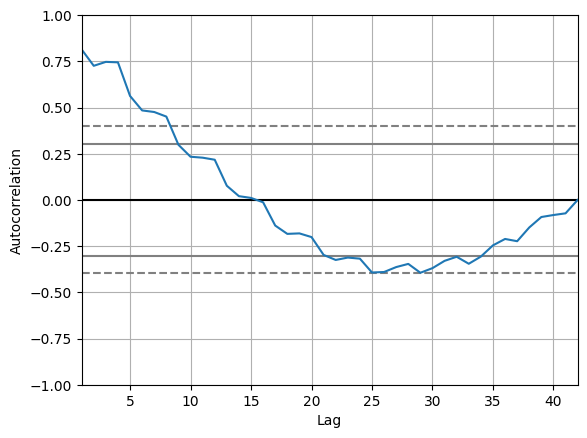

In [55]:
autocorrelation_plot(df['Sales'])

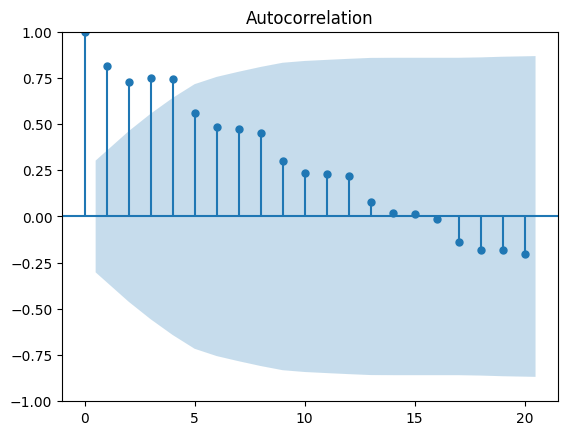

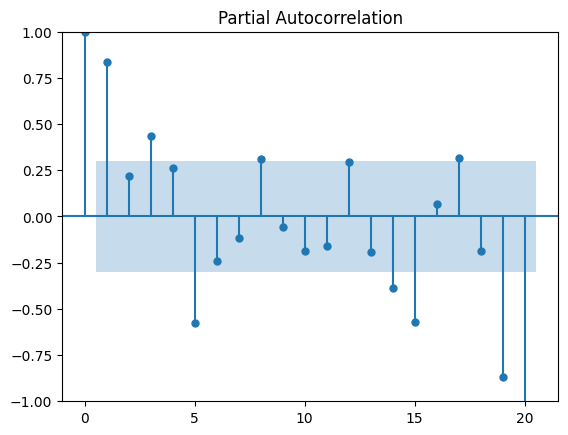

In [56]:
a=plot_acf(df['Sales'], lags=20)
pa=plot_pacf(df['Sales'], lags=20)



### Autoregressive Integrated Moving Averages (ARIMA)

In [57]:
# Will use auto ARIMA 

auto_arima_model = auto_arima(train_data["Sales"],start_p=0,
                              start_q=0,max_p=10,max_q=10,
                              m=12,start_P=0,seasonal=True,
                              d=1,D=1,trace=True,error_action="ignore",
                              suppress_warnings= True,
                              stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=295.294, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=295.908, Time=0.14 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=295.764, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=298.695, Time=0.97 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=297.278, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=297.886, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=297.741, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC

In [58]:
# Summary
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -146.647
Date:                            Thu, 02 Feb 2023   AIC                            295.294
Time:                                    11:03:21   BIC                            296.338
Sample:                                         0   HQIC                           295.521
                                             - 34                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.802e+04   2.43e+04      2.794      0.005    2.03e+04    1.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.92   Prob(JB):                         0.78
Heteroskedasticity (H):               0.62   Skew:                             0.16
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

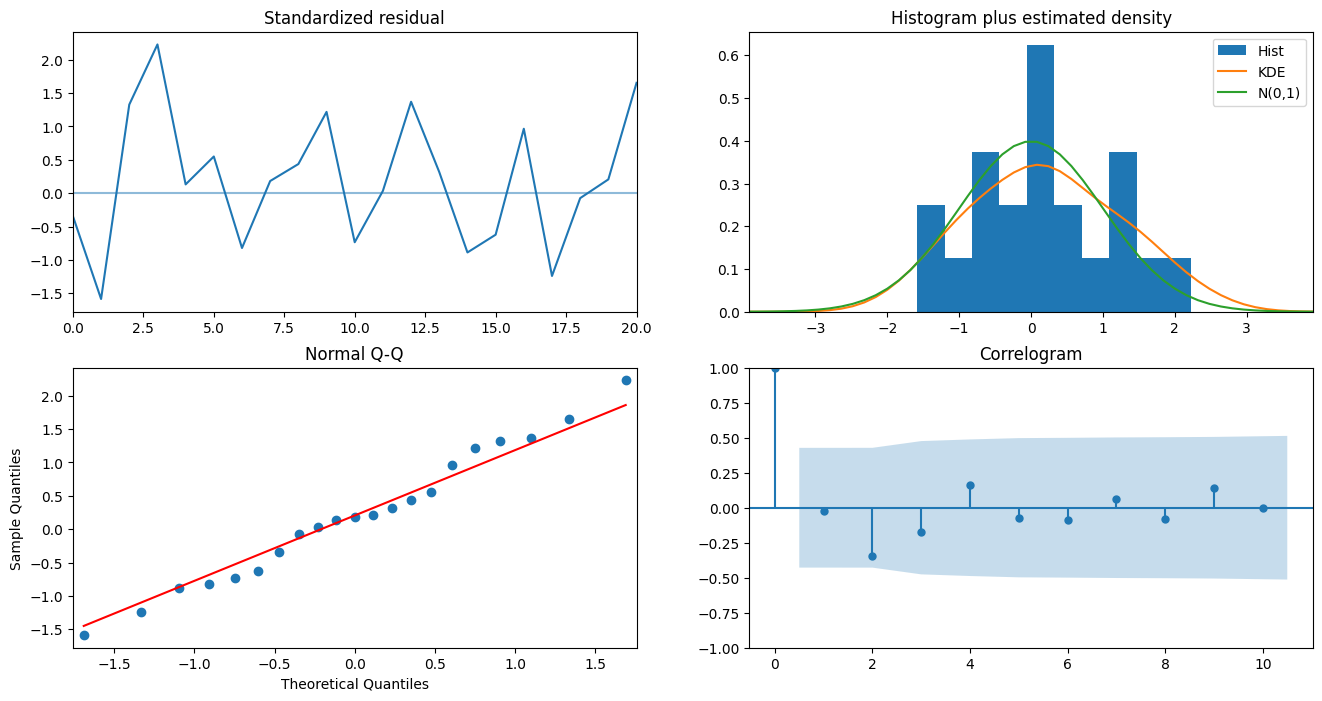

In [59]:
auto_arima_model.plot_diagnostics(figsize=(16,8))
plt.show()

In [60]:
# Storing predicted values
auto_arima_predicted=auto_arima_model.predict(n_periods=len(test_data['Sales']))


In [61]:
# Checking errors
auto_arima_error=MAPE(test_data['Sales'],auto_arima_predicted)
auto_arima_error

0.029206149323700824

In [62]:
# comparing scores auto_arima

auto_arima_trace=go.Scatter(x=test_data['Date'],y=auto_arima_predicted,name='ARIMA')
plot_me([auto_arima_trace])

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [63]:
sarima_model=sm.tsa.statespace.SARIMAX(train_data["Sales"],order = (1,1,1),seasonal_order = (1,1,1,12)).fit(disp=-1)
sarima_predicted=sarima_model.predict(start = test_data.index[0],end = test_data.index[-1])

In [64]:
# Checking what we got
sarima_trace=go.Scatter(x=test_data['Date'],y=sarima_predicted,name='SARIMA')
plot_me([sarima_trace])

In [65]:
# Checking the error we have with Simple exponential model
sarima_error=MAPE(test_data['Sales'],sarima_predicted)
sarima_error

0.04109091344326583

In [66]:
# Comparing these two model

plot_me([auto_arima_trace,sarima_trace])

Both seems same to me


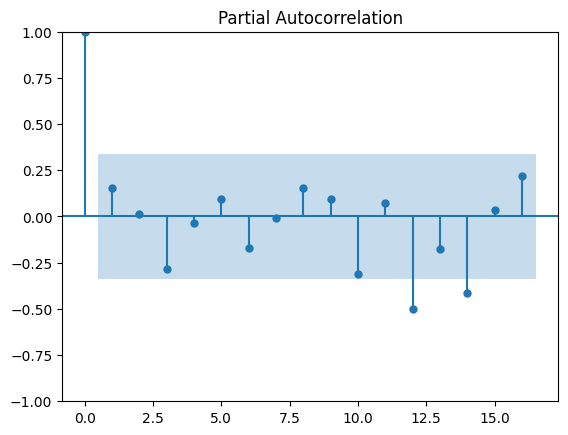

In [67]:
pa=plot_pacf(sarima_model.resid, lags=16)

### Time for model based Techniques

#### Linear Model

In [68]:
# copy of a dataframe
another_df=df.iloc[:,1:].copy()

In [69]:
# Making a count column
another_df['Range']=np.arange(1,len(another_df)+1,1)

In [70]:
# Tweak Quarters column
another_df['Quarters'].replace({1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'},inplace=True)

In [71]:
# Now labelling our data
for i in ['Year','Quarters']:
    another_df=pd.concat((another_df,pd.get_dummies(another_df.loc[:,i],drop_first=False)),axis=1)

In [72]:
another_df.head()

,Sales,Date,Year,Quarters,Range,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,1986,Q1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2244.960999,1986-04-01,1986,Q2,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2533.804993,1986-07-01,1986,Q3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2154.962997,1986-10-01,1986,Q4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1547.818996,1987-01-01,1987,Q1,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [73]:
another_df.columns

Index([   'Sales',     'Date',     'Year', 'Quarters',    'Range',       1986,
             1987,       1988,       1989,       1990,       1991,       1992,
             1993,       1994,       1995,       1996,       'Q1',       'Q2',
             'Q3',       'Q4'],
      dtype='object')

In [74]:
def scale_my_data(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def revert_my_data(y):
    return y*(np.max(df['Sales']))+np.min(df['Sales'])*(1-y)

In [75]:
# Scaling our data
another_df['Scaled_Sales']=scale_my_data(another_df['Sales'])

In [76]:
# Splitting our data
train_df,test_df=another_df.iloc[:math.ceil(len(another_df)*0.8),],another_df.iloc[math.ceil(len(another_df)*0.8):,]

In [77]:
# Model building

linear_model = smf.ols('Scaled_Sales~Range',data=train_df).fit()
linear_predicted = linear_model.predict(test_df['Range'])
linear_error=MAPE(test_df['Scaled_Sales'],linear_predicted)
linear_error

0.18416534452931999

In [78]:
# Visualizing it
linear_trace=go.Scatter(x=test_data['Date'],y=revert_my_data(linear_predicted),name='Linear Model')
plot_me([linear_trace])

In [79]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Scaled_Sales   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     106.8
Date:                Thu, 02 Feb 2023   Prob (F-statistic):           1.00e-11
Time:                        11:03:23   Log-Likelihood:                 34.776
No. Observations:                  34   AIC:                            -65.55
Df Residuals:                      32   BIC:                            -62.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0116      0.031      0.370      0.714      -0.052       0.076
Range          0.0162      0.002     10.337      0.000       0.013       0.019
==============================================================================
Omnibus:                        2.830   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.243   Jarque-Bera (JB):                2.526
Skew:                           0.644   Prob(JB):                        0.283
Kurtosis:                       2.646   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
# Exponential

exponential_model = smf.ols('np.log(Sales)~Range',data=train_df).fit()
exponential_predicted = exponential_model.predict(test_df['Range'])
exponential_error=MAPE(np.log(test_df['Sales']),exponential_predicted)
print(exponential_error)

exponential_trace=go.Scatter(x=test_data['Date'],y=np.exp(exponential_predicted),name='Exponential Model')
plot_me([exponential_trace])

0.012094828730178798


In [81]:
exponential_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Sales)   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     110.1
Date:                Thu, 02 Feb 2023   Prob (F-statistic):           6.90e-12
Time:                        11:03:23   Log-Likelihood:                 24.344
No. Observations:                  34   AIC:                            -44.69
Df Residuals:                      32   BIC:                            -41.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4566      0.043    174.435      0.000       7.370       7.544
Range          0.0224      0.002     10.493      0.000       0.018       0.027
==============================================================================
Omnibus:                        1.363   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.506   Jarque-Bera (JB):                0.967
Skew:                           0.411   Prob(JB):                        0.616
Kurtosis:                       2.922   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
# LInear model with quarter added
add_sea_model = smf.ols('Scaled_Sales~Q1+Q2+Q3+Q4',data=train_df).fit()
add_sea_predicted = add_sea_model.predict(test_df[['Q1','Q2','Q3','Q4']])
add_sea_error=MAPE(test_df['Scaled_Sales'],add_sea_predicted)
add_sea_error


0.6305870246485166

In [83]:
# Visualizing it
add_sea_trace=go.Scatter(x=test_data['Date'],y=revert_my_data(add_sea_predicted),name='Quarter Model')
plot_me([add_sea_trace])

In [84]:
add_sea_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Scaled_Sales   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.465
Date:                Thu, 02 Feb 2023   Prob (F-statistic):              0.244
Time:                        11:03:24   Log-Likelihood:                 12.149
No. Observations:                  34   AIC:                            -16.30
Df Residuals:                      30   BIC:                            -10.19
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2363      0.025      9.541      0.000       0.186       0.287
Q1            -0.0281      0.053     -0.534      0.597      -0.136       0.080
Q2             0.1426      0.053      2.705      0.011       0.035       0.250
Q3             0.0877      0.055      1.588      0.123      -0.025       0.200
Q4             0.0342      0.055      0.619      0.541      -0.079       0.147
==============================================================================
Omnibus:                        5.456   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                2.866
Skew:                           0.471   Prob(JB):                        0.239
Kurtosis:                       1.935   Cond. No.                     1.16e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.16e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [85]:
#Multiplicative Additive Seasonality 
mul_add_sea_model = smf.ols('np.log(Sales)~Range+Q1+Q2+Q3+Q4',data=train_df).fit()
mul_add_sea_predicted = mul_add_sea_model.predict(test_df[['Range','Q1','Q2','Q3','Q4']])
mul_add_sea_error=MAPE(np.log(test_df['Sales']),mul_add_sea_predicted)
print(mul_add_sea_error)

mul_add_sea_trace=go.Scatter(x=test_data['Date'],y=np.exp(mul_add_sea_predicted),name='Additive Quarter ')
plot_me([mul_add_sea_trace])


0.010821274920165666


In [86]:
mul_add_sea_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Sales)   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     62.43
Date:                Thu, 02 Feb 2023   Prob (F-statistic):           7.87e-14
Time:                        11:03:24   Log-Likelihood:                 37.471
No. Observations:                  34   AIC:                            -64.94
Df Residuals:                      29   BIC:                            -57.31
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9684      0.024    244.086      0.000       5.918       6.018
Range          0.0222      0.002     14.553      0.000       0.019       0.025
Q1             1.3713      0.026     53.022      0.000       1.318       1.424
Q2             1.5906      0.026     60.767      0.000       1.537       1.644
Q3             1.5502      0.027     57.296      0.000       1.495       1.606
Q4             1.4563      0.027     53.237      0.000       1.400       1.512
==============================================================================
Omnibus:                        7.411   Durbin-Watson:                   0.631
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                6.053
Skew:                           0.791   Prob(JB):                       0.0485
Kurtosis:                       4.329   Cond. No.                     1.71e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.7e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Comparing Which Model Performs Well

In [87]:
plot_me([sem_trace,hm_trace,hwe_trace,hwe_m_trace,linear_trace,exponential_trace,add_sea_trace,mul_add_sea_trace])

In [88]:
# Comparing All Errors

X=[sem_error,hm_error,hwe_error,hwe_m_error,auto_arima_error,sarima_error,linear_error,exponential_error,add_sea_error,mul_add_sea_error]
Y=['sem_error','hm_error','hwe_error','hwe_m_error','auto_arima_error','sarima_error','linear_error','exponential_error','add_sea_error','mul_add_sea_error']

fig=go.Figure(go.Bar(y=Y,
                     x=X,
                     text=np.around(X,4),
                     orientation='h',
                     marker=dict(color=X,
                                 colorscale='bluered'),
                     hovertemplate='%{y}<br>%{x}'))
fig.update_layout(title='Comparing all model errors',
                  xaxis_title='MAPE',
                  yaxis_title=None,)
fig.show()

So 'Multiplicative Additive Seasonality' model is giving the lowest MAPE

In [89]:
# all predicted values
np.exp(mul_add_sea_predicted)

34    4002.160052
35    3725.088494
36    3498.389419
37    4453.834529
38    4373.281056
39    4070.516604
40    3822.795684
41    4866.839387
dtype: float64

In [90]:
test_data

,Date,Sales
34,1994-07-01,4461.0
35,1994-10-01,4017.0
36,1995-01-01,3854.0
37,1995-04-01,4936.0
38,1995-07-01,4895.0
39,1995-10-01,4333.0
40,1996-01-01,4194.0
41,1996-04-01,5253.0


In [91]:
# Actual vs prediced

go.Figure(go.Scatter(x=test_data['Sales'],
                     y=np.exp(mul_add_sea_predicted),
                     mode='markers'),
          layout=dict(title='Actual vs Predicted',
                      autosize=False,
                      xaxis_title='Actual',
                      yaxis_title='Predicted'))